# Import Libraries and Load Data 

In [1]:
from Libraries import *

In [2]:
df = pd.read_csv(r'zillow_data.csv')
df.head(3)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900


In [3]:
florida_data = df[df['State'] == 'FL']

florida_data.head(3)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,249900,250400,249900,248700,247500,247100,246800,247500,249800,251800
60,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0,337900.0,338300.0,...,1466200,1471000,1485400,1497700,1504200,1507600,1495800,1466200,1443900,1432300
82,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0,111700.0,111800.0,...,283500,286100,287800,288800,289700,291000,292500,294200,296400,298200


In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn import metrics
import warnings
from statsmodels.tsa.stattools import adfuller
from numpy import log
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=13,8

def clean_df_zipcode_index(dataframe):
    fl_df = dataframe.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
    fl_df.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
    fl_df.set_index('Zipcode', inplace=True)
    return fl_df

def clean_df_int_index(dataframe):    
    fl_df_ = dataframe.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
    fl_df_.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
    fl_df_ = fl_df_.reset_index(drop=True)
    return fl_df_

def clean_dict(dataframe):
    fl_dict = dataframe.drop(dataframe.columns[dataframe.columns.str.contains('-')], axis=1)
    fl_dict = fl_dict.drop(['RegionID','SizeRank'], axis=1)
    fl_dict.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
    fl_dict = fl_dict.reset_index(drop=True)
    fl_dict = fl_dict.set_index('Zipcode')
    return fl_dict

def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

def melt_data_mean(df):
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

def multi_index_df(df):
    df_full = clean_df_int_index(df)
    df_full_melt = melt_data(df_full)
    ts = df_full_melt.set_index('time')
    fl_df_comprehensive = ts.groupby(['Zipcode']).resample('M').sum()
    fl_df_comprehensive = fl_df_comprehensive.drop('Zipcode', axis=1)
    return fl_df_comprehensive

def get_top_cities(dictionary, key):
    for i, j in dictionary.items(): 
        if i in key: 
            top_5_cities.append(j['City'])      

def get_bottom_cities(dictionary, key):
    for i, j in dictionary.items(): 
        if i in key: 
            bottom_5_cities.append(j['City'])

def plot_train_test_pred(train, test, prediction_df):
    fig, ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train, label='Train')
    ax.plot(test, label='Test', color='red')
    ax.plot(prediction_df['prediction'], label='prediction', ls=':', color='black')

    ax.fill_between(x=prediction_df.index, y1=prediction_df.lower, y2=prediction_df.upper, ls='-', color='grey', alpha=0.3)

    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout
    return fig, ax

def forecast_to_dataframe(forecast, zipcode):
    test_predictions = forecast.conf_int()
    test_predictions[zipcode] = forecast.predicted_mean
    test_predictions.columns = ['lower','upper','prediction']
    return test_predictions

### Clean and Restructure Data 

In [5]:
fl_df_comprehensive = multi_index_df(florida_data)

fl_df_comprehensive.head()

value
Zipcode time                
32003   1996-04-30  135500.0
        1996-05-31  136000.0
        1996-06-30  136700.0
        1996-07-31  137700.0
        1996-08-31  139000.0

In [6]:
reset = fl_df_comprehensive.reset_index(level=0)
reset.head(3)

,Zipcode,value
time,,
1996-04-30,32003,135500.0
1996-05-31,32003,136000.0
1996-06-30,32003,136700.0


In [7]:
zipcode_list_ = reset['Zipcode'].unique().tolist()

time_series_dict = {}

for zipcode in zipcode_list_:
    temp_series = reset.groupby('Zipcode').get_group(zipcode).sort_index()['value']
    time_series_dict[zipcode] = temp_series

In [8]:
test_zip = 32003
time_series_dict[test_zip]

time
1996-04-30    135500.0
1996-05-31    136000.0
1996-06-30    136700.0
1996-07-31    137700.0
1996-08-31    139000.0
                ...   
2017-12-31    271300.0
2018-01-31    272800.0
2018-02-28    273400.0
2018-03-31    274300.0
2018-04-30    275300.0
Name: value, Length: 265, dtype: float64

In [9]:
final_df = pd.DataFrame(time_series_dict)
final_df.dropna(axis=1, inplace=True)
final_df.head()

zipcode_list = final_df.columns.tolist()

[32003,
 32008,
 32009,
 32011,
 32024,
 32025,
 32034,
 32040,
 32043,
 32055,
 32060,
 32063,
 32064,
 32065,
 32068,
 32073,
 32080,
 32081,
 32082,
 32084,
 32086,
 32087,
 32092,
 32095,
 32097,
 32102,
 32112,
 32113,
 32114,
 32117,
 32118,
 32119,
 32124,
 32127,
 32128,
 32129,
 32130,
 32131,
 32132,
 32134,
 32136,
 32137,
 32141,
 32148,
 32159,
 32162,
 32163,
 32164,
 32168,
 32169,
 32174,
 32176,
 32177,
 32179,
 32180,
 32181,
 32187,
 32189,
 32193,
 32195,
 32204,
 32205,
 32207,
 32210,
 32211,
 32216,
 32217,
 32218,
 32219,
 32220,
 32221,
 32222,
 32223,
 32224,
 32225,
 32226,
 32233,
 32234,
 32244,
 32246,
 32250,
 32256,
 32257,
 32258,
 32259,
 32266,
 32277,
 32301,
 32303,
 32304,
 32305,
 32308,
 32309,
 32310,
 32311,
 32312,
 32317,
 32320,
 32322,
 32324,
 32327,
 32328,
 32333,
 32346,
 32347,
 32348,
 32351,
 32352,
 32358,
 32359,
 32401,
 32404,
 32405,
 32407,
 32408,
 32409,
 32413,
 32420,
 32428,
 32431,
 32433,
 32439,
 32440,
 32442,
 32443,


# Data Preprocessing

time
1996-04-30    135500.0
1996-05-31    136000.0
1996-06-30    136700.0
1996-07-31    137700.0
1996-08-31    139000.0
                ...   
2017-12-31    271300.0
2018-01-31    272800.0
2018-02-28    273400.0
2018-03-31    274300.0
2018-04-30    275300.0
Freq: M, Name: 32003, Length: 265, dtype: float64

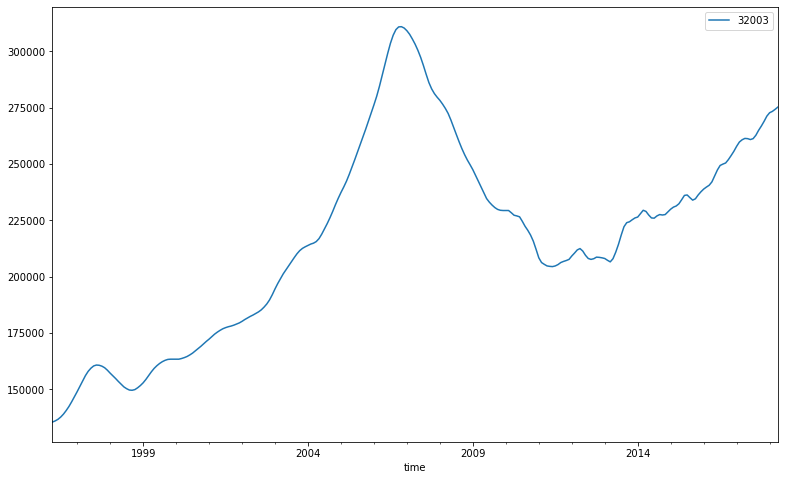

In [10]:
test_series = final_df[32003].copy()
ax = test_series.plot()
ax.legend()
test_series

### Check ACF/PACF for Test Series

#### Autocorrelation Function 

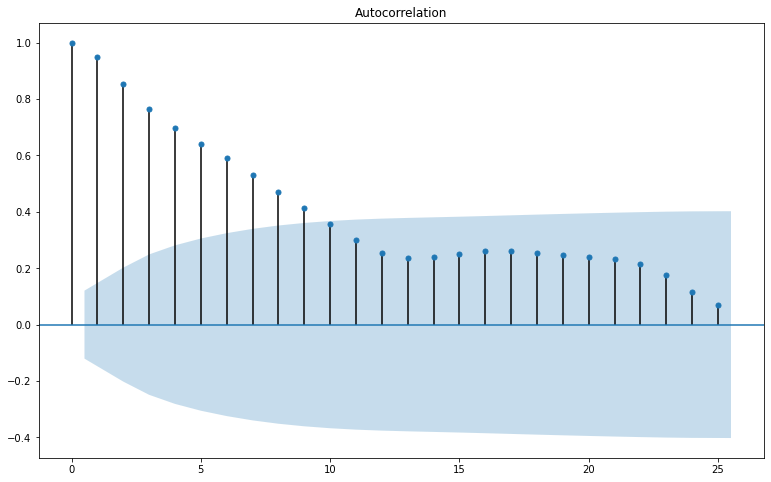

In [11]:
plot_acf(test_series.diff(1).dropna());

#### Partial Autocorrelation Function

In [ ]:
plot_pacf(test_series.dropna());

In [13]:
test_series

time
1996-04-30    135500.0
1996-05-31    136000.0
1996-06-30    136700.0
1996-07-31    137700.0
1996-08-31    139000.0
                ...   
2017-12-31    271300.0
2018-01-31    272800.0
2018-02-28    273400.0
2018-03-31    274300.0
2018-04-30    275300.0
Freq: M, Name: 32003, Length: 265, dtype: float64

### Create Training and Testing Sets for Test Series

In [14]:
train_pct = 0.8
split_index = round(len(test_series)*train_pct)
split_index

212

In [15]:
train = test_series.iloc[:split_index]
test = test_series.iloc[split_index:]

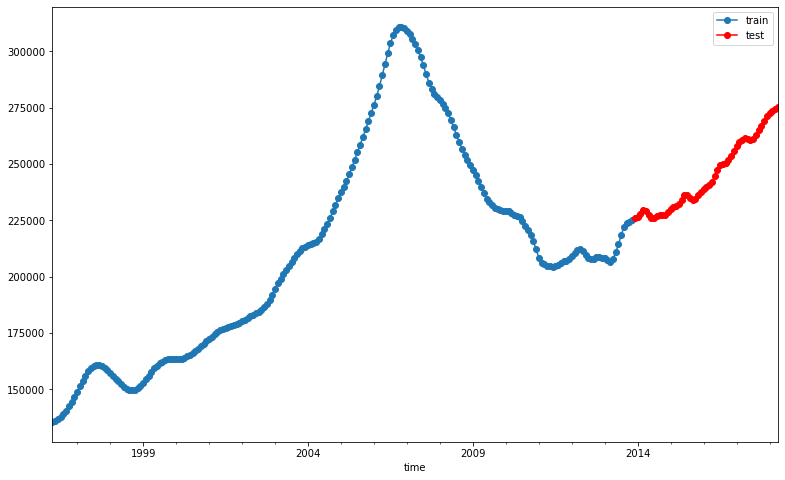

In [16]:
fig, ax = plt.subplots()
kws = dict(ax=ax, marker='o')
train.plot(**kws, label='train')
test.plot(**kws, label='test', color='red')
ax.legend(bbox_to_anchor=[1,1]);

# ARIMA Modeling

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  32003   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1862.077
Date:                Mon, 14 Dec 2020   AIC                           3730.154
Time:                        02:42:02   BIC                           3740.209
Sample:                    04-30-1996   HQIC                          3734.218
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9068      0.023     38.926      0.000       0.861       0.952
ma.L1         -0.8573      0.027    -32.275      0.000      -0.909      -0.805
sigma2      2.461e+06   6.56e-10   3.75e+15      0.000    2.46e+06    2.46e+06
===================================================================================
Ljung-Box (Q):                      848.41   Jarque-Bera (JB):                 2.86
Prob(Q):                              0.00   Prob(JB):                         0.24
Heteroskedasticity (H):               1.47   Skew:                            -0.28
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.07e+31. Standard errors may be unstable.
"""

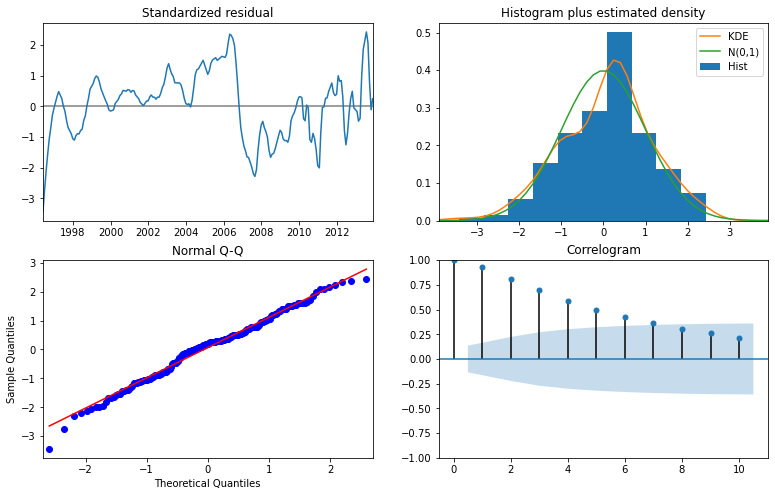

In [17]:
p = 1
d = 1
q = 1

model = SARIMAX(train, order=(p,d,q)).fit()

display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1597.889
Date:                Mon, 14 Dec 2020   AIC                           3199.778
Time:                        02:42:03   BIC                           3206.472
Sample:                             0   HQIC                          3202.484
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0479      0.009      5.532      0.000       0.031       0.065
sigma2      2.291e+05    1.3e+04     17.632      0.000    2.04e+05    2.55e+05
===================================================================================
Ljung-Box (Q):                      167.15   Jarque-Bera (JB):               124.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.51   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

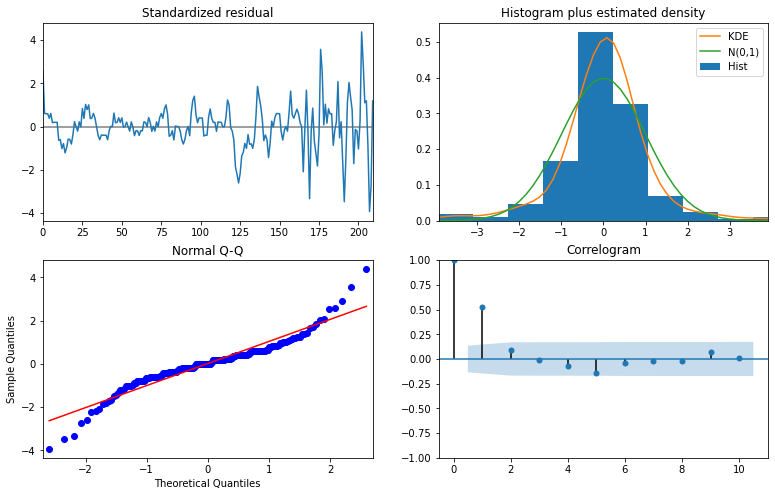

In [19]:
auto_arima_model = auto_arima(train, start_p=0, start_q=0)
display(auto_arima_model.summary())
auto_arima_model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  32003   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2036.985
Date:                Mon, 14 Dec 2020   AIC                           4077.970
Time:                        03:18:02   BIC                           4085.114
Sample:                    04-30-1996   HQIC                          4080.841
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0466      0.008      5.692      0.000       0.031       0.063
sigma2      3.034e+05   1.78e+04     17.010      0.000    2.68e+05    3.38e+05
===================================================================================
Ljung-Box (Q):                      164.34   Jarque-Bera (JB):                61.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.81   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

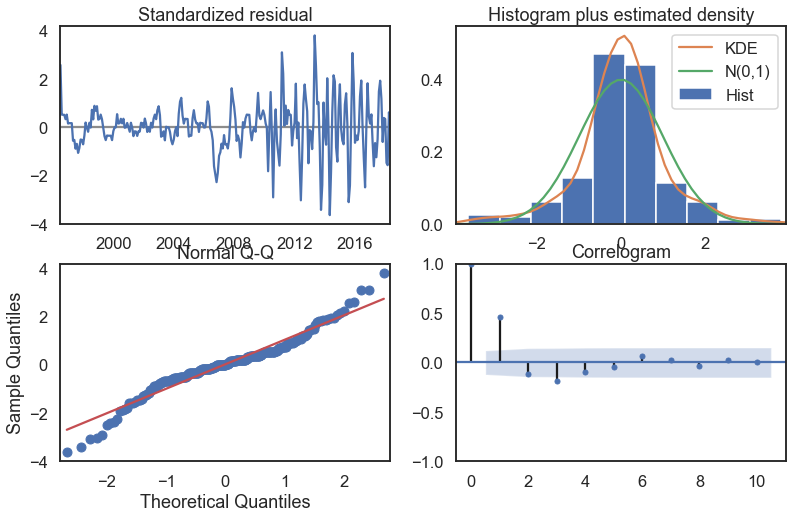

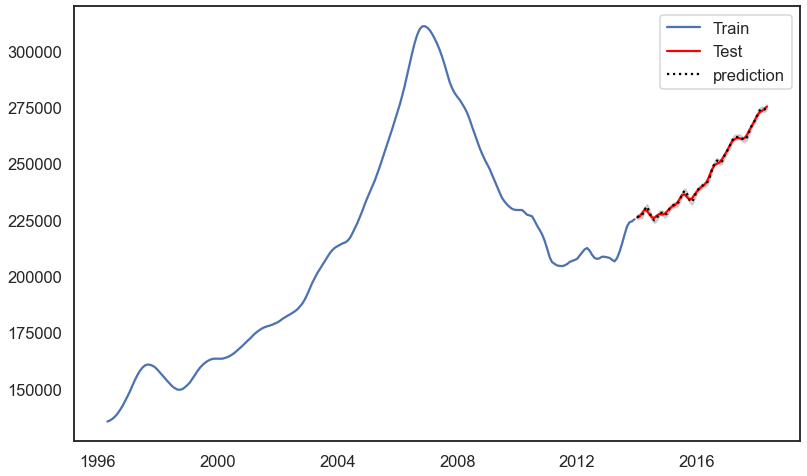

In [60]:
best_model = SARIMAX(test_series, order=auto_arima_model.order,
                     seasonal_order=auto_arima_model.seasonal_order).fit()

display(best_model.summary())
best_model.plot_diagnostics()

prediction_best_model = best_model.get_prediction(start=test.index[0], end=test.index[-1])

prediction_df = forecast_to_dataframe(prediction_best_model, test_zip)

plot_train_test_pred(train, test, prediction_df);

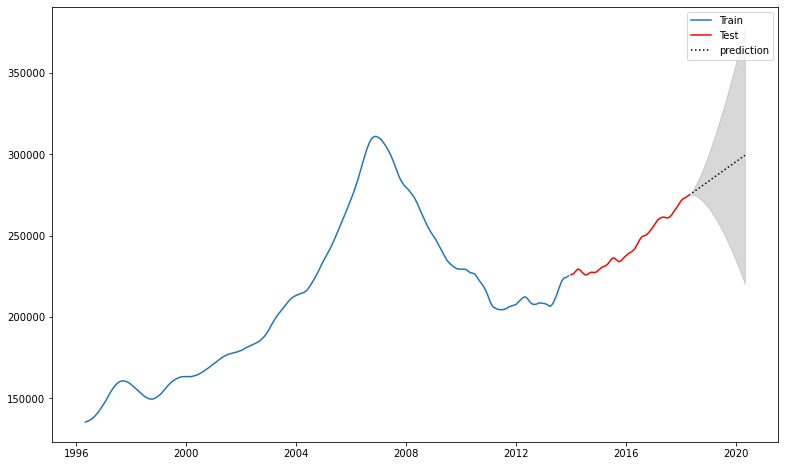

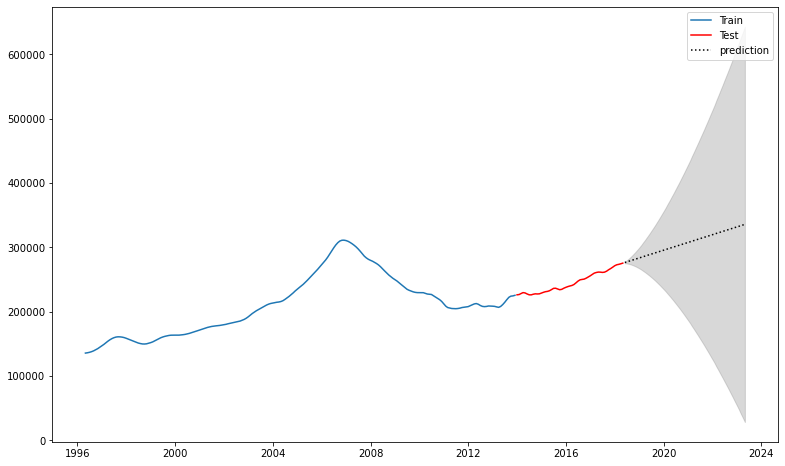

In [21]:
pred_2yr = best_model.get_forecast(steps=24)
pred_5yr = best_model.get_forecast(steps=60)

pred_2yr_df = forecast_to_dataframe(pred_2yr, test_zip)
pred_5yr_df = forecast_to_dataframe(pred_5yr, test_zip)

plot_train_test_pred(train, test, pred_2yr_df)
plot_train_test_pred(train, test, pred_5yr_df);

In [22]:
results = {}

for zipcode in zipcode_list:
    
    zipcode_dict = {}
    
    fl_time_series = final_df[zipcode].copy()
    
    # train/test split
    train_pct = 0.8
    split_index = round(len(fl_time_series)*train_pct)
    split_index
    
    train_ = fl_time_series.iloc[:split_index]
    test_ = fl_time_series.iloc[split_index:]
    
    
    model_ = SARIMAX(test_, order=auto_arima_model.order,
                     seasonal_order=auto_arima_model.seasonal_order).fit()
    
    zipcode_dict['train'] = train_
    zipcode_dict['test'] = test_
    zipcode_dict['model'] = model_
    
    pred_2yrs = model_.get_forecast(steps=24)
    pred_2yrs_df = forecast_to_dataframe(pred_2yrs, zipcode)
    zipcode_dict['upper'] = pred_2yrs_df['upper']
    zipcode_dict['lower'] = pred_2yrs_df['lower']
    zipcode_dict['prediction'] = pred_2yrs_df['prediction']
    
    results[zipcode] = zipcode_dict


In [23]:
returns_list = []

for zipcode in results:
    pct_change = (results[zipcode]['prediction'][-1] - results[zipcode]['train'][0]) / (results[zipcode]['train'][0]) * (100)
    returns_list.append([pct_change, zipcode])

In [48]:
returns_list_max = []

for zipcode in results:
    pct_change = (results[zipcode]['upper'][-1] - results[zipcode]['train'][0]) / (results[zipcode]['train'][0]) * (100)
    returns_list_max.append([pct_change, zipcode])

In [49]:
#sorted(returns_list, reverse=True)

sorted(returns_list_max, reverse=True)

[[1219.833424284556, 32320],
 [1136.7571580000485, 32455],
 [1124.3118311114397, 33701],
 [1108.0191773588494, 33137],
 [1036.2529068195588, 32461],
 [1026.3110683409045, 33181],
 [987.2332482943955, 32621],
 [960.1680156739459, 33139],
 [950.9746127720875, 32680],
 [934.639009684576, 32696],
 [912.5136256414145, 33716],
 [881.5934601964168, 32358],
 [880.7563733646624, 33947],
 [840.811658813608, 32619],
 [828.4906177502608, 32625],
 [819.0442269893442, 32456],
 [806.0602043443474, 32693],
 [793.5139764659963, 32346],
 [775.6595678038218, 34449],
 [753.2614440134278, 33704],
 [744.874126078386, 32686],
 [731.9719939159265, 32204],
 [710.9484023414665, 32193],
 [709.713733794366, 33606],
 [708.2955790667794, 32628],
 [701.6351556209835, 33316],
 [696.1004898568729, 32626],
 [695.9457477440554, 33141],
 [688.6722455155135, 33129],
 [679.2181100654827, 32709],
 [670.2617593320613, 33931],
 [666.3223358805707, 32948],
 [663.7366172130494, 33602],
 [661.6100969187206, 33513],
 [661.4319344

<Figure size 936x576 with 0 Axes>

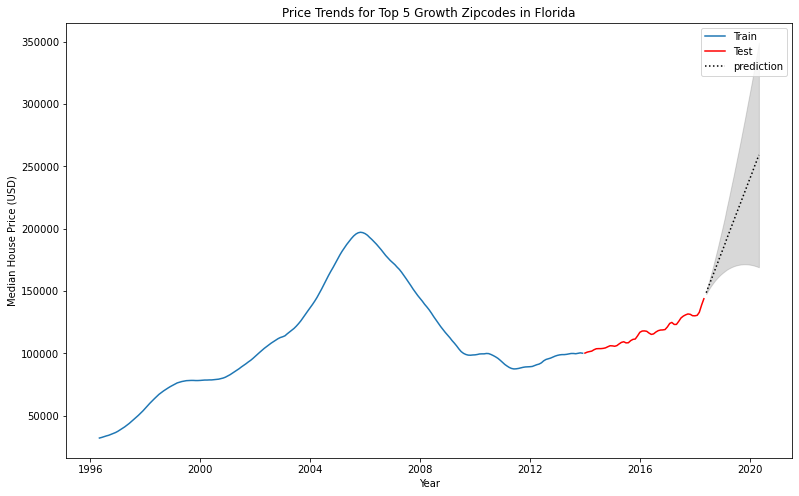

<Figure size 936x576 with 0 Axes>

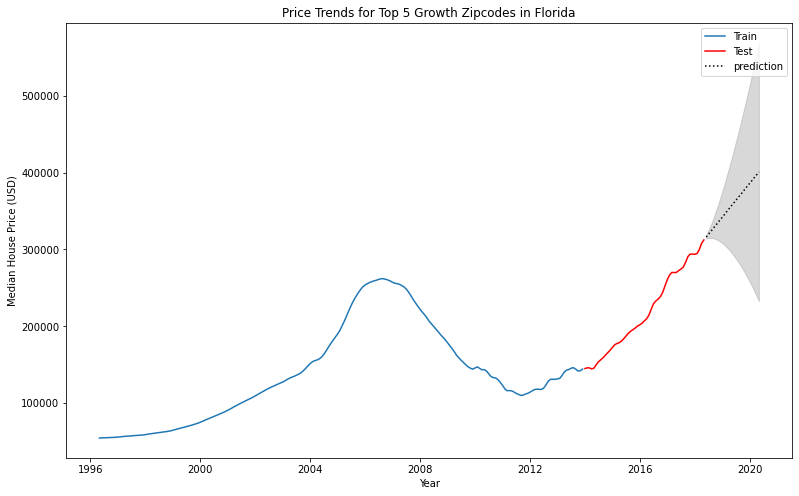

<Figure size 936x576 with 0 Axes>

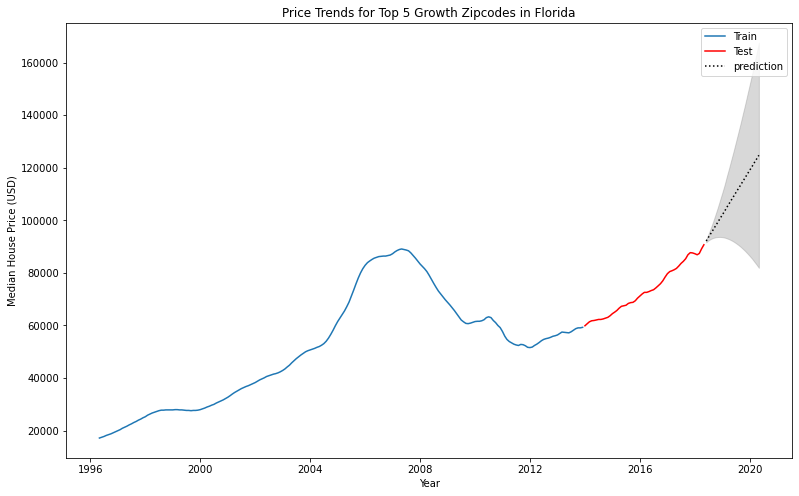

<Figure size 936x576 with 0 Axes>

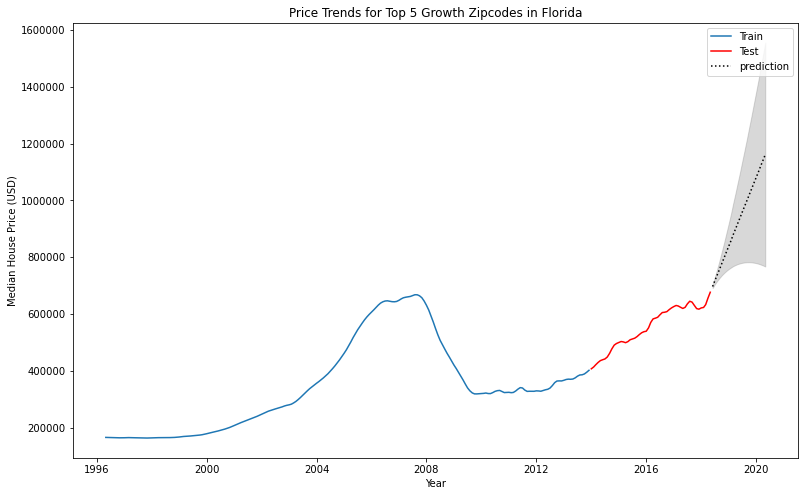

<Figure size 936x576 with 0 Axes>

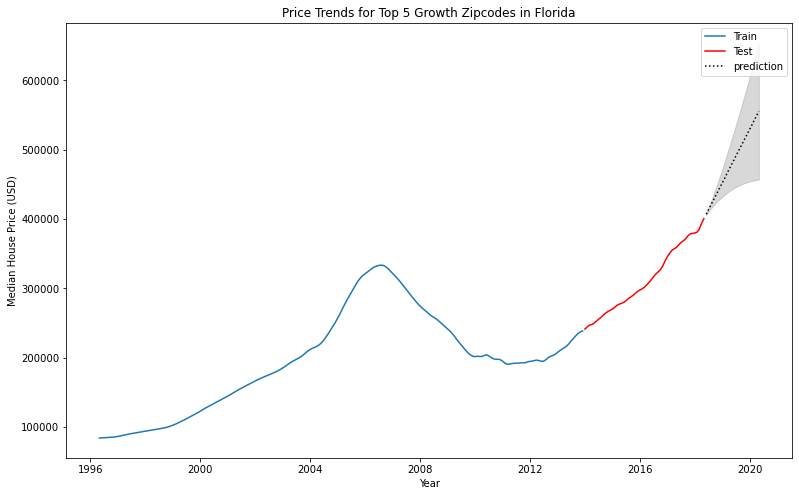

In [25]:
top_5_zips = [32320, 33701, 32680, 33181, 33704]


for _zipcode_ in top_5_zips:
    plt.figure()
    model = SARIMAX(final_df[_zipcode_], order=auto_arima_model.order,
                    seasonal_order=auto_arima_model.seasonal_order).fit()
    
    train__ = final_df[_zipcode_].iloc[:split_index]
    test__ = final_df[_zipcode_].iloc[split_index:]
    predict_2yr = model.get_forecast(steps=24)
    predict_2yr_df = forecast_to_dataframe(predict_2yr, _zipcode_)
    plot_train_test_pred(train__, test__, predict_2yr_df)
    
    plt.title('Price Trends for Top 5 Growth Zipcodes in Florida')
    plt.xlabel('Year')
    plt.ticklabel_format(axis='y', style='plain')
    plt.ylabel('Median House Price (USD)');

## ARIMA Modeling with All Zipcodes

In [26]:
fuller_df = melt_data_mean(clean_df_int_index(florida_data))
result = adfuller(fuller_df['value'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.630457
p-value: 0.467252


In [51]:
train_fuller = fuller_df['value'].iloc[:split_index]
test_fuller = fuller_df['value'].iloc[split_index:]

In [28]:
fuller_df.head()

,value
time,
1996-04-01,104529.019608
1996-05-01,104594.117647
1996-06-01,104662.352941
1996-07-01,104727.058824
1996-08-01,104816.993464


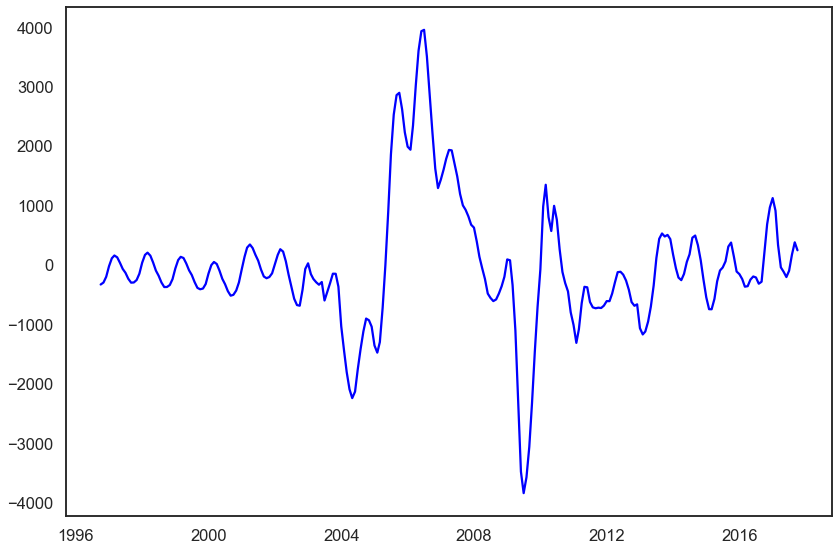

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = sm.tsa.seasonal_decompose(fuller_df, model='additive')

residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.plot(residual, label='Residuals', color='blue')
plt.tight_layout()

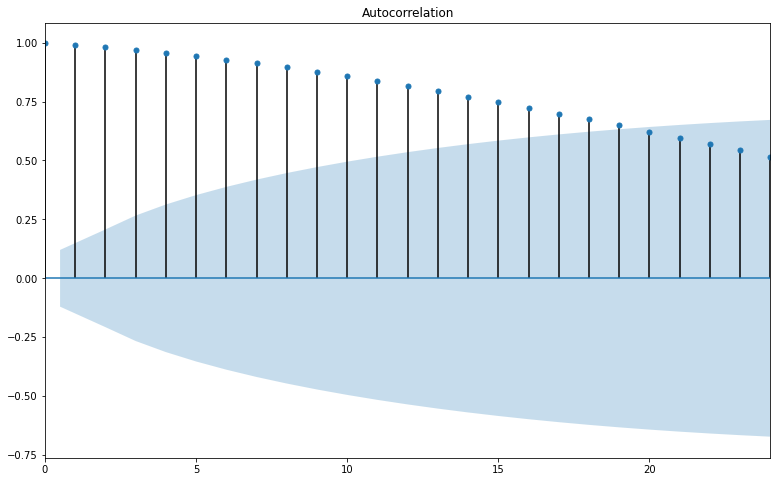

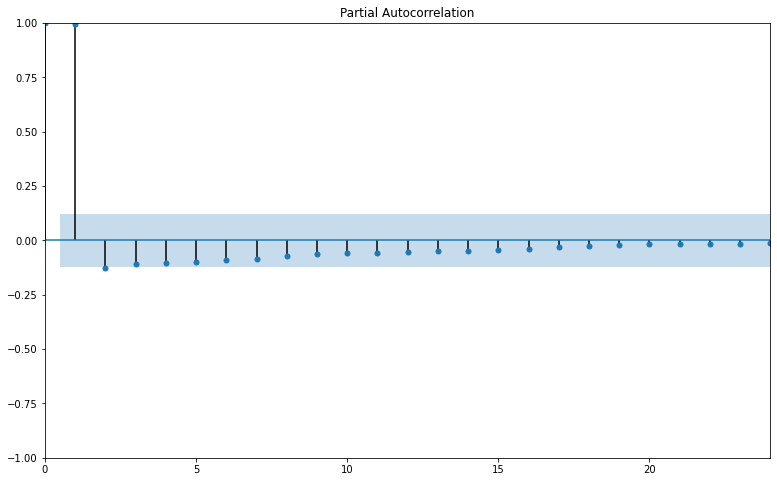

In [30]:
rcParams['figure.figsize']=13,8

plot_acf(fuller_df); plt.xlim(0,24); plt.show()
plot_pacf(fuller_df); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

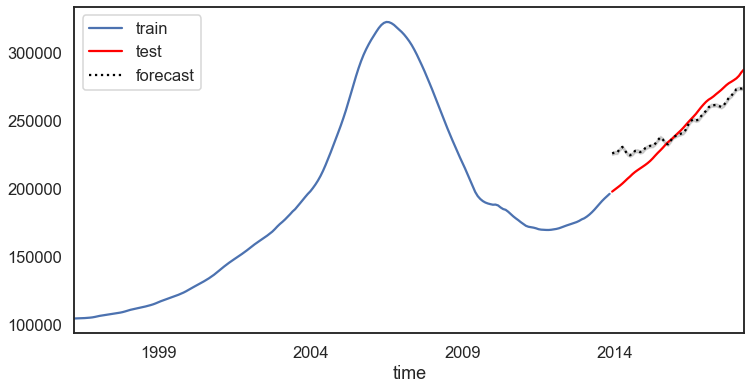

In [52]:
fig, ax = plt.subplots()
train_fuller.plot(ax=ax, label='train')
test_fuller.plot(ax=ax, label='test', color='red')
prediction_df['prediction'].plot(ax=ax, label='forecast', ls=':', color='black')

ax.fill_between(x=prediction_df.index, y1=prediction_df.lower, y2=prediction_df.upper, ls='-', color='grey', alpha=0.3)

ax.legend();

In [32]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [33]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(fuller_df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ans

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7216.813041412668
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6733.7645058405105
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5875.0030664264405
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5608.11919836012
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5887.494035942432
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5800.882024499652
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5440.736229581077
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5420.7592879807835
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6999.017677781154
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6636.963908232914
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5864.292163593193
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =8211.80909495856
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7081.379747784174
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6619.570142541327
ARIMA (0, 0, 1) x (

[[(0, 0, 0), (0, 0, 0, 12), 7216.813041412668],
 [(0, 0, 0), (0, 0, 1, 12), 6733.7645058405105],
 [(0, 0, 0), (0, 1, 0, 12), 5875.0030664264405],
 [(0, 0, 0), (0, 1, 1, 12), 5608.11919836012],
 [(0, 0, 0), (1, 0, 0, 12), 5887.494035942432],
 [(0, 0, 0), (1, 0, 1, 12), 5800.882024499652],
 [(0, 0, 0), (1, 1, 0, 12), 5440.736229581077],
 [(0, 0, 0), (1, 1, 1, 12), 5420.7592879807835],
 [(0, 0, 1), (0, 0, 0, 12), 6999.017677781154],
 [(0, 0, 1), (0, 0, 1, 12), 6636.963908232914],
 [(0, 0, 1), (0, 1, 0, 12), 5864.292163593193],
 [(0, 0, 1), (0, 1, 1, 12), 8211.80909495856],
 [(0, 0, 1), (1, 0, 0, 12), 7081.379747784174],
 [(0, 0, 1), (1, 0, 1, 12), 6619.570142541327],
 [(0, 0, 1), (1, 1, 0, 12), 5830.77698804295],
 [(0, 0, 1), (1, 1, 1, 12), 7641.211934148969],
 [(0, 1, 0), (0, 0, 0, 12), 4833.982590907675],
 [(0, 1, 0), (0, 0, 1, 12), 4447.92057885861],
 [(0, 1, 0), (0, 1, 0, 12), 4486.294703872583],
 [(0, 1, 0), (0, 1, 1, 12), 4266.67334411157],
 [(0, 1, 0), (1, 0, 0, 12), 4468.465800030

In [34]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3430.72
Name: 63, dtype: object

In [35]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(fuller_df, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9800      0.011     89.725      0.000       0.959       1.001
ma.L1          0.3312      0.019     17.501      0.000       0.294       0.368
ar.S.L12      -0.4731      0.060     -7.853      0.000      -0.591      -0.355
ma.S.L12      15.0582      4.951      3.041      0.002       5.355      24.762
sigma2       412.2228    272.184      1.515      0.130    -121.248     945.693


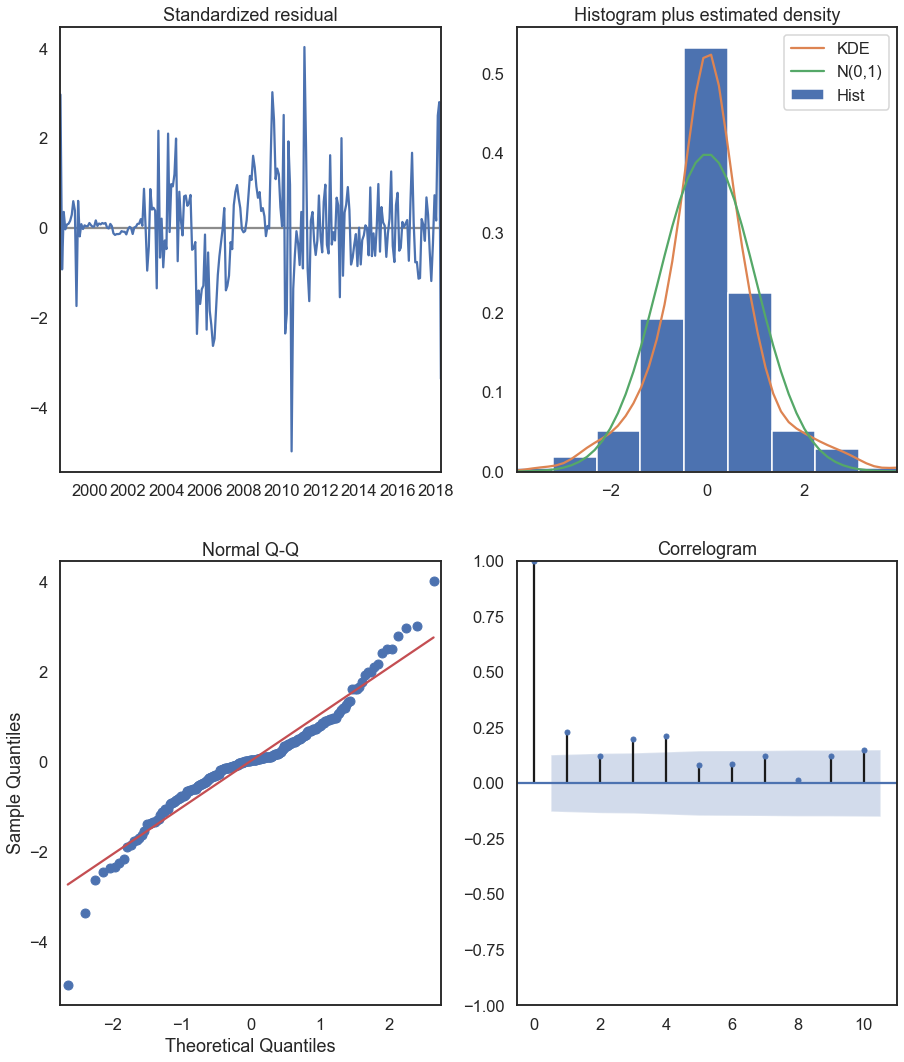

In [36]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [54]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [56]:
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

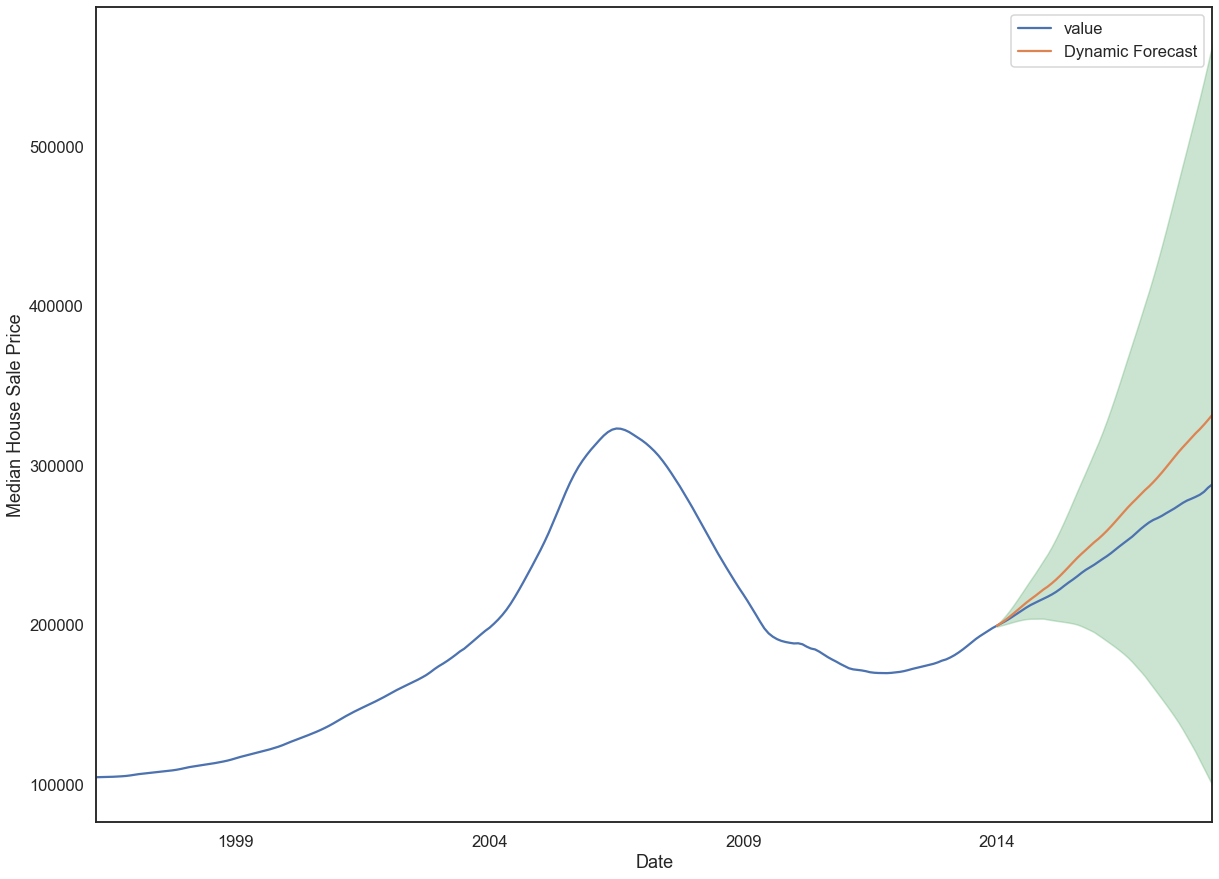

In [67]:
ax = fuller_df['1996-04-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.set_xlabel('Date')
ax.set_ylabel('Median House Sale Price')

plt.legend()
plt.show()

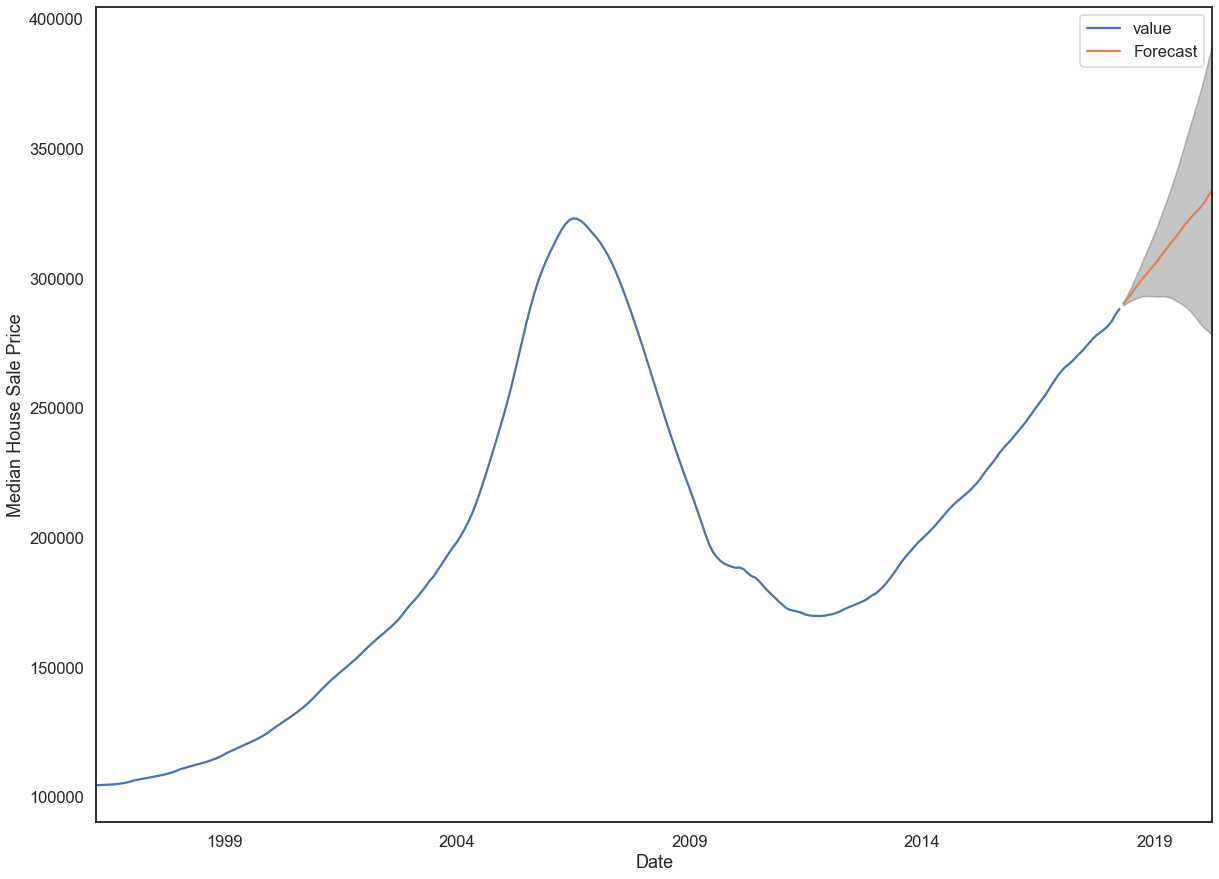

In [65]:
# Plot future predictions with confidence intervals
ax = fuller_df.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median House Sale Price')

plt.legend()
plt.show()

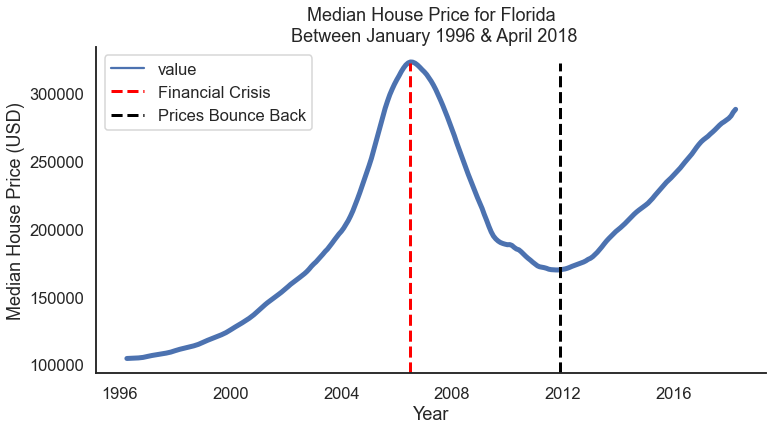

In [31]:
sns.set(rc={'figure.figsize':(12,6)},style="white", context="talk")

ax = sns.lineplot(data=fuller_df, color='g', lw=5);

ax.axvline(x=pd.to_datetime('2006-07-01'), ymin=0, ymax=0.95, ls= "--", lw=3, color='red', label='Financial Crisis')
ax.axvline(x=pd.to_datetime('2011-12-01'), ymin=0, ymax=0.95, ls= "--", lw=3, color='black', label='Prices Bounce Back')


title = 'Median House Price for Florida\n Between January 1996 & April 2018'
ax.set_title(title)

xlabel = 'Year'
ylabel = "Median House Price (USD)"
ax.set(xlabel=xlabel, ylabel=ylabel)

sns.despine()
plt.legend();

##### code scraps

In [ ]:
dict_df = clean_dict(florida_data)

fl_dict_names = dict_df.to_dict(orient='index')

print(list(fl_dict_names)[0:5])

In [ ]:
wide = clean_df_zipcode_index(florida_data)
long = wide.transpose()

florida_df = long.dropna(axis='columns')

florida_df.tail()

In [ ]:
wide['Percent Change'] = (wide['2018-04'] - wide['1996-04']) / (wide['1996-04']) * 100

top_5_wide = wide.nlargest(5, ['Percent Change'])
top_5 = top_5_wide.transpose()
top_5.drop(top_5.tail(1).index, inplace=True)
top_5 = top_5.sort_values(by='2018-04', axis=1, ascending=False)

top_5.tail()

In [ ]:
bottom_5_wide = wide.nsmallest(5, ['Percent Change'])
bottom_5 = bottom_5_wide.transpose()
bottom_5.drop(bottom_5.tail(1).index, inplace=True)
bottom_5 = bottom_5.sort_values(by='2018-04', axis=1, ascending=False)

bottom_5.tail()

In [ ]:
top_5.plot(figsize=(21,13))

key = top_5.columns
top_5_cities = []

get_top_cities(fl_dict_names, key)

plt.legend(top_5_cities)

plt.title('Price Trends for Top 5 Growth Zipcodes in Florida')
plt.xlabel('Year')
plt.ylabel('Median House Price (USD)');

In [ ]:
bottom_5.plot(figsize=(21,13))

key2 = bottom_5.columns

bottom_5_cities = []
get_bottom_cities(fl_dict_names, key2)

plt.legend(bottom_5_cities)
plt.title('Price Trends for 5 Lowest Growth Zipcodes in Florida')
plt.xlabel('Year')
plt.ylabel('Median House Price (USD)');